In [1]:
import numpy as np
import pandas as pd
import zipfile
import gc
gc.enable()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path="/content/drive/MyDrive/Data_btp2/"
train=zipfile.ZipFile(path+"data_train"+".zip","r")
test=zipfile.ZipFile(path+"data_test"+".zip","r")

In [4]:
data_train = pd.read_csv(train.open('data_train.csv'))
data_test = pd.read_csv(test.open('data_test.csv'))

In [5]:
X = data_train.drop(['reordered', 'uxp_ratio_last_five'], axis=1)
y = data_train.reordered

In [7]:
from lightgbm import LGBMClassifier

In [8]:
pip install scikit-plot

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold,RandomizedSearchCV
from sklearn.metrics import f1_score, classification_report
from scikitplot.metrics import plot_confusion_matrix
from scikitplot.classifiers import plot_feature_importances

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [ ]:
hyperparameters = {
                  
                  "max_depth": [1,2,3,4,5,6,7,8,9,10],
                  "num_leaves":[2, 4, 8, 16, 32, 64, 128, 256, 512, 1024],
                  "learning_rate":[0.0001, 0.001, 0.01, 0.1, 1.0]
                  }

LGB = LGBMClassifier(random_state=10)

randomizedsearch = RandomizedSearchCV(LGB, hyperparameters , n_iter=5,cv=10,scoring='f1',random_state=66 , verbose = 5)

model = randomizedsearch.fit(X_train,y_train)

print('mean test scores',model.cv_results_['mean_test_score'])
print(model.best_estimator_)

In [13]:
clf = LGBMClassifier(max_depth=2, num_leaves=128, random_state=10)

clf.fit(X_train,y_train)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=2,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=128, objective=None,
               random_state=10, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [14]:
y_pred = (clf.predict_proba(X_test)[:, 1] >= 0.21).astype('int')

F1 Score: 0.42823977494048904
              precision    recall  f1-score   support

           0       0.91      0.94      0.93   2212941
           1       0.50      0.38      0.43    329458

    accuracy                           0.87   2542399
   macro avg       0.70      0.66      0.68   2542399
weighted avg       0.86      0.87      0.86   2542399



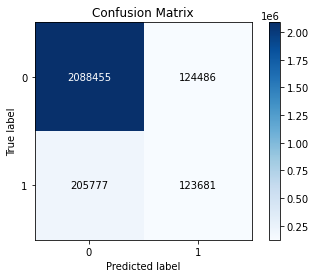

In [15]:
print('F1 Score: {}'.format(f1_score(y_pred, y_test)))
print(classification_report(y_pred, y_test))
plot_confusion_matrix(y_pred, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_feature_importances is deprecated; This will be removed in v0.4.0. Please use scikitplot.estimators.plot_feature_importances instead.
  warnings.warn(msg, category=FutureWarning)


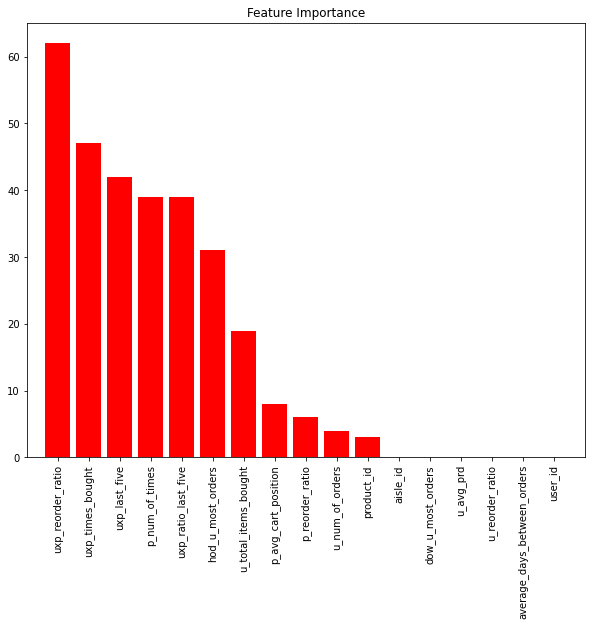

In [16]:
plot_feature_importances(clf, feature_names=data_test.columns, x_tick_rotation=90, max_num_features=20, figsize=(10,8))

In [17]:
# Entire Data
clf.fit(data_train.drop(['reordered', 'uxp_ratio_last_five'], axis=1), data_train.reordered)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=2,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=128, objective=None,
               random_state=10, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [19]:
y_pred_test = (clf.predict_proba(data_test.drop('uxp_ratio_last_five', axis=1))[:, 1] >= 0.21).astype('int')

In [20]:
data_test['prediction'] = y_pred_test
data_test.head()

,user_id,product_id,uxp_times_bought,uxp_reorder_ratio,uxp_last_five,uxp_ratio_last_five,u_num_of_orders,u_avg_prd,dow_u_most_orders,hod_u_most_orders,u_reorder_ratio,average_days_between_orders,u_total_items_bought,p_num_of_times,p_reorder_ratio,p_avg_cart_position,aisle_id,department_id,prediction
0,3,248,1,0.090909,0.0,0.0,12,7.333333,0,16,0.625,13.590909,88,6371,0.400251,10.620782,0.070016,0.088504,0
1,3,1005,1,0.333333,1.0,0.2,12,7.333333,0,16,0.625,13.590909,88,463,0.440605,9.498920,0.066098,0.126562,0
2,3,1819,3,0.333333,0.0,0.0,12,7.333333,0,16,0.625,13.590909,88,2424,0.492162,9.287541,0.063782,0.037791,0
3,3,7503,1,0.100000,0.0,0.0,12,7.333333,0,16,0.625,13.590909,88,12474,0.553551,9.547379,0.070016,0.088504,0
4,3,8021,1,0.090909,0.0,0.0,12,7.333333,0,16,0.625,13.590909,88,27864,0.591157,8.822854,0.095193,0.054678,0


In [21]:
final = data_test.reset_index()
# Keep only the required columns to create our submission file (for chapter 6)
final = final[['product_id', 'user_id', 'prediction']]

gc.collect()
final.head()

,product_id,user_id,prediction
0,248,3,0
1,1005,3,0
2,1819,3,0
3,7503,3,0
4,8021,3,0


In [23]:
orders=zipfile.ZipFile(path+"orders"+".zip","r")
orders = pd.read_csv(orders.open('orders.csv'))

In [24]:
orders_test = orders.loc[orders.eval_set == 'test', ['user_id', 'order_id']]
orders_test.head()

,user_id,order_id
38,3,2774568
44,4,329954
53,6,1528013
96,11,1376945
102,12,1356845


In [25]:
final = final.merge(orders_test, on='user_id', how='left')
final.head()

,product_id,user_id,prediction,order_id
0,248,3,0,2774568
1,1005,3,0,2774568
2,1819,3,0,2774568
3,7503,3,0,2774568
4,8021,3,0,2774568


In [26]:
final = final.drop('user_id', axis=1)

In [27]:
final['product_id'] = final.product_id.astype(int)

del orders
del orders_test
gc.collect()

final.head()

,product_id,prediction,order_id
0,248,0,2774568
1,1005,0,2774568
2,1819,0,2774568
3,7503,0,2774568
4,8021,0,2774568


In [28]:
d = dict()
for row in final.itertuples():
    if row.prediction== 1:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in final.order_id:
    if order not in d:
        d[order] = 'None'
        
gc.collect()

148

In [29]:
sub = pd.DataFrame.from_dict(d, orient='index')

#Reset index
sub.reset_index(inplace=True)
#Set column names
sub.columns = ['order_id', 'products']

sub.head()

,order_id,products
0,2774568,17668 18599 21903 22035 39190 43961 47766
1,1528013,21903 38293
2,1376945,8309 13176 14947 27959 28465 33572 34658 35948...
3,1356845,7076 10863 13176 14992
4,2161313,196 10441 11266 12427 14715 27839 37710


In [30]:
sub.to_csv('sub.csv', index=False, header=True)


In [32]:
from PIL import Image

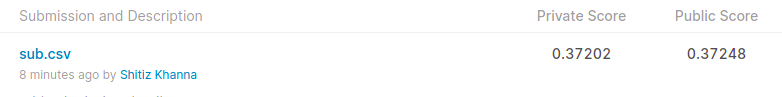

In [33]:
img = Image.open("Kaggle_1.png")
img